## Train Model

In [1]:
import h5py
import sys
sys.path.append('/home/ztang/multitask_RNA/evaluation/')
import mpra_model
import numpy as np
import os
import tensorflow as tf
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
from sklearn import model_selection
import scipy.stats
celltype = 'K562'

2023-05-04 17:39:23.813545: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-04 17:39:24.419468: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
file = '/home/ztang/multitask_RNA/data/lenti_MPRA/'+celltype+'_onehot_rc.h5'
f = h5py.File(file, 'r')
x = f['onehot'][()]
y = f['target'][()]
x = np.swapaxes(x,1,2)
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.1, random_state=42)

## Multiple models for ensemble

In [3]:
model_count = 1
for i in range(model_count):
    model = mpra_model.MPRAnn((None,230,4),(None,1))
    earlyStopping_callback = tf.keras.callbacks.EarlyStopping(
                patience=10, restore_best_weights=True
            )
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

    checkpoint = tf.keras.callbacks.ModelCheckpoint('/home/ztang/multitask_RNA/model_rep/MPRAnn/'+celltype+'/model_'+str(i)+'.h5',
                                        monitor='val_loss',
                                        save_best_only=True,
                                        mode = 'min',
                                        save_freq='epoch',)
    model.compile(
                    loss="mean_squared_error",
                    metrics=["mse", "mae"],
                    optimizer=optimizer,
                )
    result = model.fit(x_train,y_train,
        batch_size=64,
        validation_split=0.1,
        epochs=100,
        shuffle=True,
        verbose=2,
        callbacks=[earlyStopping_callback,checkpoint],
    )
    tf.keras.backend.clear_session()


2023-05-04 17:39:30.686591: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78865 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:07:00.0, compute capability: 8.0


Epoch 1/100


2023-05-04 17:39:35.867773: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-05-04 17:39:36.439351: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-05-04 17:39:36.440844: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x55990f54c060 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-04 17:39:36.440862: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2023-05-04 17:39:36.444525: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-05-04 17:39:36.561859: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the pro

5728/5728 - 35s - loss: 0.2034 - mse: 0.2034 - mae: 0.3449 - val_loss: 0.2339 - val_mse: 0.2339 - val_mae: 0.3562 - 35s/epoch - 6ms/step
Epoch 2/100
5728/5728 - 29s - loss: 0.1821 - mse: 0.1821 - mae: 0.3258 - val_loss: 0.1835 - val_mse: 0.1835 - val_mae: 0.3359 - 29s/epoch - 5ms/step
Epoch 3/100
5728/5728 - 28s - loss: 0.1724 - mse: 0.1724 - mae: 0.3167 - val_loss: 0.1736 - val_mse: 0.1736 - val_mae: 0.3258 - 28s/epoch - 5ms/step
Epoch 4/100
5728/5728 - 28s - loss: 0.1658 - mse: 0.1658 - mae: 0.3106 - val_loss: 0.1848 - val_mse: 0.1848 - val_mae: 0.3275 - 28s/epoch - 5ms/step
Epoch 5/100
5728/5728 - 29s - loss: 0.1611 - mse: 0.1611 - mae: 0.3063 - val_loss: 0.1668 - val_mse: 0.1668 - val_mae: 0.3059 - 29s/epoch - 5ms/step
Epoch 6/100
5728/5728 - 28s - loss: 0.1567 - mse: 0.1567 - mae: 0.3018 - val_loss: 0.1608 - val_mse: 0.1608 - val_mae: 0.3028 - 28s/epoch - 5ms/step
Epoch 7/100
5728/5728 - 28s - loss: 0.1533 - mse: 0.1533 - mae: 0.2987 - val_loss: 0.1649 - val_mse: 0.1649 - val_mae:

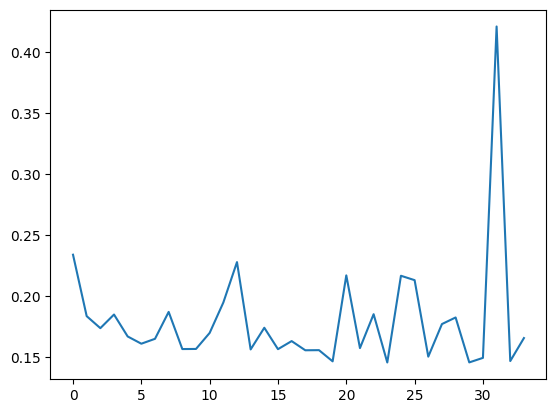

In [13]:
import matplotlib.pyplot as plt
plt.plot(result.history['val_loss'])

In [14]:
y_pred = np.zeros(y_test.shape)
for i in range(model_count):
    model = tf.keras.models.load_model('/home/ztang/multitask_RNA/model_rep/MPRAnn/'+celltype+'/model_'+str(i)+'.h5')
    y_pred += np.squeeze(model.predict(x_test))

1415/1415 [==============================] - 2s 1ms/step


In [15]:
y_pred = y_pred / model_count
scipy.stats.pearsonr(y_test, y_pred)

PearsonRResult(statistic=0.6946396922381959, pvalue=0.0)

## Test model on corresponding CAGI

In [16]:
import tensorflow as tf
from tensorflow import keras
import h5py
import scipy.stats
import numpy as np
import os
import pandas as pd
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
celltype = 'K562'
model_num = 0

In [17]:
model = tf.keras.models.load_model('/home/ztang/multitask_RNA/model_rep/MPRAnn/'+celltype+'/model_'+str(model_num)+'.h5')

In [18]:
file = h5py.File("/home/ztang/multitask_RNA/data/CAGI/"+celltype+"/onehot.h5", "r")
alt = file['alt']
ref = file['ref']
alt_pred = model.predict(alt)
ref_pred = model.predict(ref)
pred = alt_pred - ref_pred

45/45 [==============================] - 0s 1ms/step


In [19]:
exp_df = pd.read_csv('/home/ztang/multitask_RNA/data/CAGI/'+celltype+'/metadata.csv')
target = exp_df['6'].values.tolist()

In [20]:
start_idx=0
perf = []
for exp in exp_df['8'].unique():
    sub_df = exp_df[exp_df['8'] == exp]
    exp_target = target[start_idx:sub_df.index[-1]+1]
    exp_pred = np.squeeze(pred)[start_idx:sub_df.index[-1]+1]
    print(exp)
    perf.append(scipy.stats.pearsonr(exp_pred,exp_target)[0])
    print(scipy.stats.pearsonr(exp_pred,exp_target)[0])

PKLR
0.3686260139129207


In [12]:
np.mean(perf)

0.3686260139129207